In [1]:
import pandas as pd
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk

# Download VADER lexicon
nltk.download('vader_lexicon')

# Load your dataset
df = pd.read_csv('/content/Merged file.csv')

# Initialize VADER sentiment analyzer
sid = SentimentIntensityAnalyzer()

# Function to classify sentiment based on VADER's compound score
def vader_sentiment(text):
    # Convert the input to string if it's not already
    # This handles cases where the input is a float
    if not isinstance(text, str):
        text = str(text)

    score = sid.polarity_scores(text)['compound']
    if score >= 0.05:
        return 'Positive'
    elif score <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

# Apply VADER sentiment analysis to the 'Post Body' column
df['Sentiment'] = df['Tweet_Content'].apply(vader_sentiment)

# Display the first few rows with the new 'Sentiment' column
print(df[['Tweet_Content', 'Sentiment']].head())

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


                                       Tweet_Content Sentiment
0  Shahid Khaqan Abbasi Slams Budget 2024-25 as t...  Negative
1  One of insurance sector undervalued stock is g...  Positive
2  Some picture broken heart 💔\nOnly pakistan zin...  Negative
3  #Budget2024 : A look at India's GDP Growth rat...  Positive
4  The #Budget2024 discussions kick in today. Amo...  Positive


In [2]:
# Map the sentiments to numerical values (Positive: 0, Negative: 1, Neutral: 2)
df['Sentiment_Label'] = df['Sentiment'].map({'Positive': 0, 'Negative': 1, 'Neutral': 2})

# Check the distribution of labels
print(df['Sentiment_Label'].value_counts())

Sentiment_Label
0    4196
2    3142
1    2441
Name: count, dtype: int64


In [3]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df['Tweet_Content'], df['Sentiment_Label'], test_size=0.05, random_state=128)

In [4]:
import torch
from transformers import BertTokenizer

# Load BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Function to tokenize and encode the text data
def encode_data(texts, labels, max_len=128):
    input_ids = []
    attention_masks = []

    for text in texts:
        # Check if the text is a valid string, otherwise fill with an empty string
        if isinstance(text, str):
            encoded = tokenizer.encode_plus(
                text,
                add_special_tokens=True,
                max_length=max_len,
                pad_to_max_length=True,
                return_attention_mask=True,
                return_tensors='pt'
            )
            input_ids.append(encoded['input_ids'])
            attention_masks.append(encoded['attention_mask'])
        else:
            # Handle missing or invalid values (e.g., NaN) by encoding an empty string
            encoded = tokenizer.encode_plus(
                '',  # Encode an empty string
                add_special_tokens=True,
                max_length=max_len,
                pad_to_max_length=True,
                return_attention_mask=True,
                return_tensors='pt'
            )
            input_ids.append(encoded['input_ids'])
            attention_masks.append(encoded['attention_mask'])

    return torch.cat(input_ids, dim=0), torch.cat(attention_masks, dim=0), torch.tensor(labels)

# Encode the training and testing data
train_inputs, train_masks, train_labels = encode_data(train_texts.tolist(), train_labels.tolist())
test_inputs, test_masks, test_labels = encode_data(test_texts.tolist(), test_labels.tolist())

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2870: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad

In [5]:
from torch.utils.data import DataLoader, TensorDataset, RandomSampler, SequentialSampler
from transformers import BertForSequenceClassification, AdamW

# Create TensorDatasets for training and testing sets
train_data = TensorDataset(train_inputs, train_masks, train_labels)
test_data = TensorDataset(test_inputs, test_masks, test_labels)

# Create DataLoader for training and testing sets
train_dataloader = DataLoader(train_data, sampler=RandomSampler(train_data), batch_size=16)
test_dataloader = DataLoader(test_data, sampler=SequentialSampler(test_data), batch_size=16)

# Load pre-trained BERT model with sequence classification head
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=3,  # We have 3 sentiment labels (Positive, Negative, Neutral)
    output_attentions=False,
    output_hidden_states=False
)

# Set up the optimizer
optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)

# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [7]:
from transformers import get_linear_schedule_with_warmup

# Define the total number of training steps
epochs = 10
total_steps = len(train_dataloader) * epochs

# Set up the scheduler
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,  # You can increase this if you'd like to warm up the learning rate for a few steps
    num_training_steps=total_steps
)


In [ ]:
# Training loop
epochs = 10
for epoch in range(epochs):
    model.train()

    total_loss = 0

    for step, batch in enumerate(train_dataloader):
        batch_input_ids, batch_masks, batch_labels = batch[0].to(device), batch[1].to(device), batch[2].to(device)

        model.zero_grad()

        outputs = model(batch_input_ids, token_type_ids=None, attention_mask=batch_masks, labels=batch_labels)
        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()
        optimizer.step()

    print(f'Epoch {epoch + 1} - Loss: {total_loss / len(train_dataloader)}')

print("Training complete!")

Epoch 1 - Loss: 0.6289248508425259
Epoch 2 - Loss: 0.27932900907519864
Epoch 3 - Loss: 0.14686037199780114
Epoch 4 - Loss: 0.08770758391994335
Epoch 5 - Loss: 0.06578582575105503
Epoch 6 - Loss: 0.046336818102542025
Epoch 7 - Loss: 0.03732014470182683
Epoch 8 - Loss: 0.04054557441334238
Epoch 9 - Loss: 0.025925992556201236


Accuracy: 86.75%


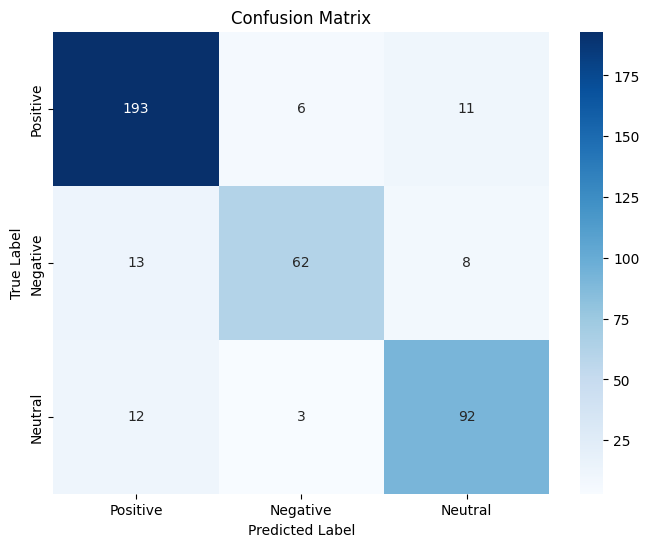

Classification Report:
               precision    recall  f1-score   support

    Positive       0.89      0.92      0.90       210
    Negative       0.87      0.75      0.81        83
     Neutral       0.83      0.86      0.84       107

    accuracy                           0.87       400
   macro avg       0.86      0.84      0.85       400
weighted avg       0.87      0.87      0.87       400

Precision: 0.87
Recall: 0.87
F1 Score: 0.87


In [19]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Model evaluation
model.eval()
predictions, true_labels = [], []

# Evaluate the model on the test set
for batch in test_dataloader:
    batch_input_ids, batch_masks, batch_labels = batch[0].to(device), batch[1].to(device), batch[2].to(device)

    with torch.no_grad():
        outputs = model(batch_input_ids, token_type_ids=None, attention_mask=batch_masks)

    logits = outputs.logits
    predictions.append(torch.argmax(logits, dim=1).cpu().numpy())
    true_labels.append(batch_labels.cpu().numpy())

# Flatten the predictions and true labels
predictions = [item for sublist in predictions for item in sublist]
true_labels = [item for sublist in true_labels for item in sublist]

# Calculate accuracy
accuracy = accuracy_score(true_labels, predictions)
print(f"Accuracy: {accuracy * 100:.2f}%")

# Confusion Matrix
cm = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Positive', 'Negative', 'Neutral'], yticklabels=['Positive', 'Negative', 'Neutral'])
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
report = classification_report(true_labels, predictions, target_names=['Positive', 'Negative', 'Neutral'])
print("Classification Report:\n", report)

# Calculate precision, recall, and F1-score
precision = precision_score(true_labels, predictions, average='weighted')
recall = recall_score(true_labels, predictions, average='weighted')
f1 = f1_score(true_labels, predictions, average='weighted')

print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')

In [24]:
def predict_sentiment(tweet):
    encoded_tweet = tokenizer.encode_plus(
        tweet,
        add_special_tokens=True,
        max_length=128,
        return_attention_mask=True,
        return_tensors='pt',
        pad_to_max_length=True
    )

    input_ids = encoded_tweet['input_ids'].to(device)
    attention_mask = encoded_tweet['attention_mask'].to(device)

    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)

    prediction = torch.argmax(outputs.logits, dim=1).item()

    sentiment_map = {0: "Positive", 1: "Negative", 2: "Neutral"}
    return sentiment_map[prediction]

# Test with a new tweet
new_tweet = "Among the many demands for tax relief is that more non metro cities be included for a 50% HRA exemption"
predicted_sentiment = predict_sentiment(new_tweet)
print(f"Predicted Sentiment: {predicted_sentiment}")

Predicted Sentiment: Positive


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2870: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Index(['Keyword', 'Post_URL', 'Author_Name', 'Author_Web_Page_URL',
       'Author_Handle', 'Verified_Status', 'UTC_Time', 'Ads', 'Tweet_Content',
       'Post_ID', 'Reply_Count', 'Repost_Count', 'Like_Count', 'View_Count',
       'Bookmark_Count', 'Tweet_Image_URL', 'Replying_to', 'Reply_to_Whom',
       'Reply_to_Whom_URL', 'Reply_to_Whom_Username', 'Reply_to_Whom_Handle',
       'Language', 'Sentiment', 'Sentiment_Label'],
      dtype='object')


<ipython-input-23-7e6047fa9800>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=handle_tweet_counts.index, y=handle_tweet_counts.values, palette='viridis')
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128509 (\N{STATUE OF LIBERTY}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127470 (\N{REGIONAL INDICATOR SYMBOL LETTER I}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127473 (\N{REGIONAL INDICATOR SYMBOL LETTER L}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarnin

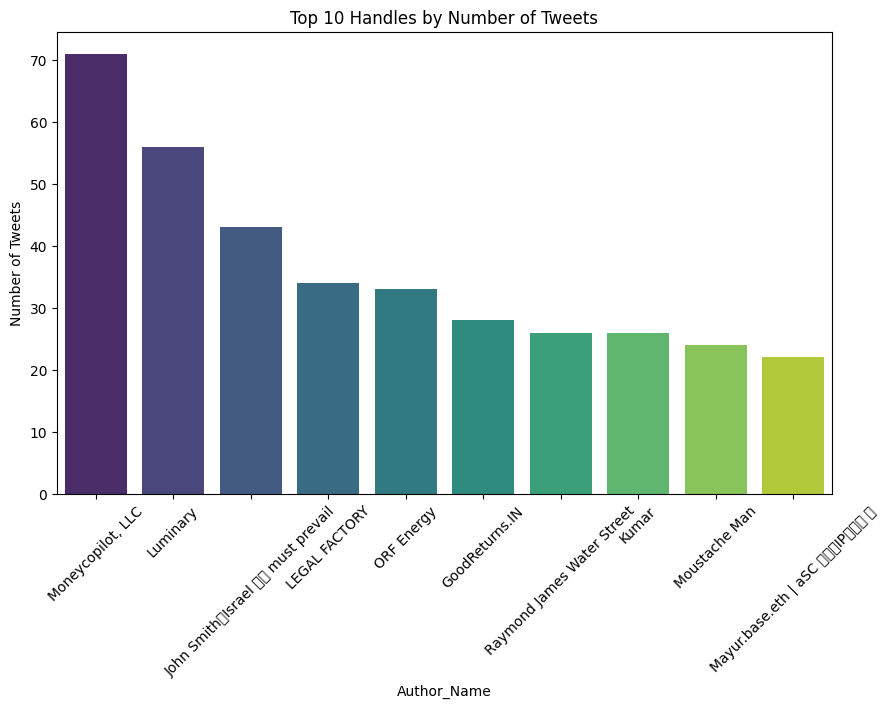

<Figure size 1600x800 with 0 Axes>

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128509 (\N{STATUE OF LIBERTY}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127470 (\N{REGIONAL INDICATOR SYMBOL LETTER I}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127473 (\N{REGIONAL INDICATOR SYMBOL LETTER L}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129521 (\N{BRICK}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128262 (\N{HIGH BRIGHTNESS SYMBOL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/pyt

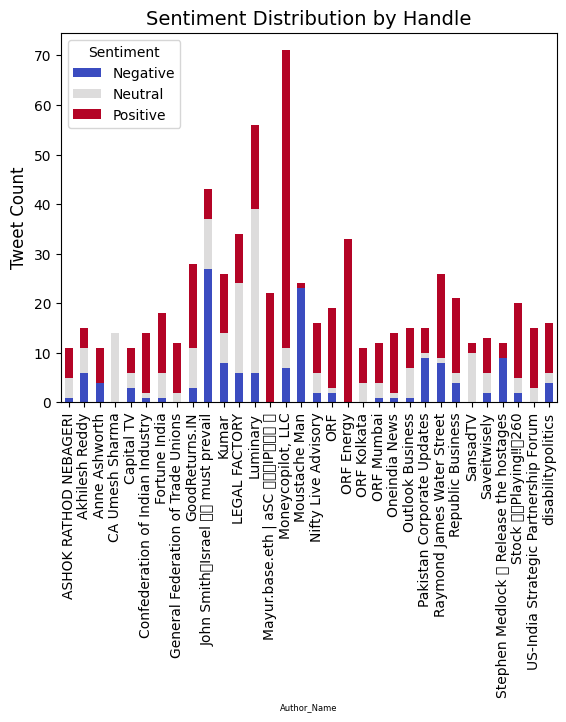

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

# Check the available columns in your DataFrame
print(df.columns)

# Replace 'Handle' with the actual column name containing the Twitter handle
# For example, if the column is named 'username', change the code to:
handle_column_name = 'Author_Name'  # Replace with your actual column name

handle_tweet_counts = df[handle_column_name].value_counts().head(10)
handle_sentiment_dist = df.groupby(handle_column_name)['Sentiment'].value_counts().unstack()

# Plot 1: Top 10 handles by number of tweets
plt.figure(figsize=(10, 6))
sns.barplot(x=handle_tweet_counts.index, y=handle_tweet_counts.values, palette='viridis')
plt.title('Top 10 Handles by Number of Tweets')
plt.xlabel(handle_column_name)  # Use the correct column name
plt.ylabel('Number of Tweets')
plt.xticks(rotation=45)
plt.show()

# Plot 2: Sentiment Distribution by Handle
plt.figure(figsize=(16, 8))
handle_sentiment_dist = handle_sentiment_dist.loc[handle_sentiment_dist.sum(axis=1) > 10]
handle_sentiment_dist.plot(kind='bar', stacked=True, colormap='coolwarm')
plt.title('Sentiment Distribution by Handle', fontsize=14)
plt.ylabel('Tweet Count', fontsize=12)
plt.xlabel(handle_column_name, fontsize=6)
plt.legend(title='Sentiment', loc='upper left', labels=['Negative', 'Neutral', 'Positive'])
plt.xticks(rotation=90)
plt.show()